# 1. Load Paramter From Config File

In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))
print("Loaded project root:", PROJECT_ROOT)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from src.dataset import DeepPHQDataset, build_vocab, create_balanced_dataloader, split_by_pid
from models.lstm.lstm_model import DeepPHQLSTM 
import yaml

# Load config
CONFIG_PATH = Path("lstm_config.yaml") 

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

config

Loaded project root: C:\Users\wange\Documents\Classes\Deep Learning\DeepPHQ


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wange\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


{'data': {'level': 'word',
  'data_root': '../../data/processed',
  'word_csv': 'word_level.csv',
  'sentence_csv': 'sentence_level.csv',
  'dialogue_csv': 'dialogue_level.csv',
  'max_length': 512},
 'vocab': {'min_freq': 1, 'pad_token': '<PAD>', 'unk_token': '<UNK>'},
 'dataloader': {'batch_size': 32, 'num_workers': 2},
 'model': {'hidden_dim': 128,
  'nhead': 4,
  'num_layers': 2,
  'dropout': 0.1,
  'output_size': 1},
 'training': {'device': 'cuda',
  'num_epochs': 10,
  'learning_rate': '3e-4',
  'weight_decay': '1e-5',
  'gradient_clip': 1.0,
  'seed': 2025},
 'checkpoint': {'save_dir': '../../models/checkpoints',
  'filename': 'deepphq_lstm.pt'}}

## 1.1 Set Seed

In [2]:
import random

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = config.get("training", {}).get("seed", 42)
set_seed(seed)
print(f"Seed set to {seed}")

Seed set to 2025


# 2. Load processed CSV data

In [3]:
data_cfg = config["data"]
root = Path(data_cfg["data_root"])

level = data_cfg["level"]

if level == "word":
    csv_path = root / data_cfg["word_csv"]
elif level == "sentence":
    csv_path = root / data_cfg["sentence_csv"]
elif level == "dialogue":
    csv_path = root / data_cfg["dialogue_csv"]
else:
    raise ValueError("Unknown level in config")

print("Loading:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Loading: ..\..\data\processed\word_level.csv


,PID,Text,PHQ_Score
0,300,out i playing me on done opportunities lot i w...,2
1,300,am i break no next i whatever alright done hig...,2
2,300,would the and they've diploma it bye parents n...,2
3,300,back someone games know probably school down b...,2
4,300,about friendship don't um annoying be out righ...,2


# 3. Build Vocab and Balanced DataLoader

In [4]:
all_texts = df["Text"].tolist()
vocab = build_vocab(all_texts, min_freq=config["vocab"]["min_freq"])

Vocab size = 8263


In [5]:
# 1. split
train_df, val_df, test_df = split_by_pid(df)

# 2. create datasets
train_dataset = DeepPHQDataset(
    data=list(zip(train_df["PID"], train_df["Text"], train_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

val_dataset = DeepPHQDataset(
    data=list(zip(val_df["PID"], val_df["Text"], val_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

test_dataset = DeepPHQDataset(
    data=list(zip(test_df["PID"], test_df["Text"], test_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

# 3. dataloaders
train_loader = create_balanced_dataloader(
    train_dataset,
    batch_size=config["dataloader"]["batch_size"]
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 4. verify shapes
batch = next(iter(train_loader))
print(batch["input_ids"].shape)
print(batch["label"].shape)
print(batch["pid"].shape)

torch.Size([32, 512])
torch.Size([32])
torch.Size([32])


# 4. Init LSTM Model

In [6]:
# ---- Load model config ----
model_cfg = config["model"]

# ---- Auto-select device ----
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)

# ---- Init model ----
model = DeepPHQLSTM(
    input_size=len(vocab),
    output_size=model_cfg["output_size"],
    hidden_dim=model_cfg["hidden_dim"],
    nhead=model_cfg["nhead"],
    num_layers=model_cfg["num_layers"],
    dropout=model_cfg["dropout"]
).to(device)

Using device: cuda


# 5. Train and Evaluate the Model

In [7]:
train_cfg = config["training"]

optimizer = AdamW(
    model.parameters(),
    lr=float(train_cfg["learning_rate"]),
    weight_decay=float(train_cfg["weight_decay"])
)
train_losses = []
val_losses = []
criterion = nn.MSELoss()

for epoch in range(train_cfg["num_epochs"]):
    model.train()
    epoch_loss = 0

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in progress:
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), train_cfg["gradient_clip"])
        optimizer.step()

        epoch_loss += loss.item()
        progress.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- compute validation loss ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

Epoch 1: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:04<00:00, 20.10it/s, loss=42.7]


Epoch 1 | Train Loss = 58.9534 | Val Loss = 79.4825


Epoch 2: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.56it/s, loss=60.9]


Epoch 2 | Train Loss = 35.9066 | Val Loss = 75.0419


Epoch 3: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.86it/s, loss=7.61]


Epoch 3 | Train Loss = 21.0266 | Val Loss = 77.0074


Epoch 4: 100%|████████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.81it/s, loss=12]


Epoch 4 | Train Loss = 11.1661 | Val Loss = 46.4208


Epoch 5: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.80it/s, loss=6.45]


Epoch 5 | Train Loss = 8.2598 | Val Loss = 65.4869


Epoch 6: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.76it/s, loss=3.25]


Epoch 6 | Train Loss = 5.6766 | Val Loss = 40.3477


Epoch 7: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.90it/s, loss=5.08]


Epoch 7 | Train Loss = 4.7336 | Val Loss = 76.7835


Epoch 8: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.77it/s, loss=3.64]


Epoch 8 | Train Loss = 4.5460 | Val Loss = 33.9154


Epoch 9: 100%|██████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.84it/s, loss=7.16]


Epoch 9 | Train Loss = 3.0140 | Val Loss = 37.1764


Epoch 10: 100%|████████████████████████████████████████████████████████████| 82/82 [00:02<00:00, 33.72it/s, loss=0.784]


Epoch 10 | Train Loss = 2.3382 | Val Loss = 44.3136


# 6. Save Result as pt Format

In [8]:
save_dir = Path(config["checkpoint"]["save_dir"])
level = config["data"]["level"]   # "word", "sentence", "dialogue"

model_name = f"{level}.pt"
save_path = save_dir / model_name

save_dir.mkdir(parents=True, exist_ok=True)

torch.save({
    "model_state": model.state_dict(),
    "vocab": vocab,
    "config": config,
}, save_path)

print(f"[✓] Saved model to: {save_path}")

[✓] Saved model to: ..\..\models\checkpoints\word.pt


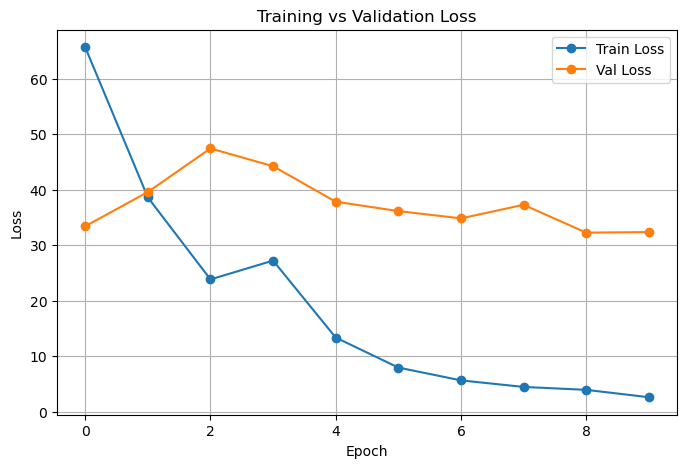

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()